In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import roc_auc_score,classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_plot,pdp_isolate 

In [24]:
#Loading the supreme court database
#data = pd.read_csv('data/SCDB_2018_02_caseCentered_Citation.csv',encoding='ISO 8859-1')
data = pd.read_csv('data/SCDB_2019_01_caseCentered_Citation.csv',encoding='ISO 8859-1')
data.shape

(8966, 53)

In [20]:
#Selecting all float columns, they should have been int cols, due to Null values they are designated as Float columns
float_columns = data.select_dtypes('float64').columns
#Replacing all null values with 9999 to convert the float columns to Int
data[float_columns] = data[float_columns].fillna(-1)
for col in float_columns:
    data[col] = data[col].astype('int')


In [21]:
data.columns

Index(['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision',
       'decisionType', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'term',
       'naturalCourt', 'chief', 'docket', 'caseName', 'dateArgument',
       'dateRearg', 'petitioner', 'petitionerState', 'respondent',
       'respondentState', 'jurisdiction', 'adminAction', 'adminActionState',
       'threeJudgeFdc', 'caseOrigin', 'caseOriginState', 'caseSource',
       'caseSourceState', 'lcDisagreement', 'certReason', 'lcDisposition',
       'lcDispositionDirection', 'declarationUncon', 'caseDisposition',
       'caseDispositionUnusual', 'partyWinning', 'precedentAlteration',
       'voteUnclear', 'issue', 'issueArea', 'decisionDirection',
       'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2',
       'lawType', 'lawSupp', 'lawMinor', 'majOpinWriter', 'majOpinAssigner',
       'splitVote', 'majVotes', 'minVotes'],
      dtype='object')

In [ ]:
#if AdminAction value is 117

In [30]:
data['is_adminAction'] = data['adminAction'].isna().astype(int)
data['is_adminActionState']=data['adminActionState'].isna().astype(int)

In [31]:
max(data['is_adminAction']+data['is_adminActionState'])

2

In [33]:
data[(~data['adminAction'].isna())&(~data['adminActionState'].isna())][['adminAction','adminActionState']]

,adminAction,adminActionState
5,117.0,6.0
8,117.0,2.0
23,117.0,17.0
27,117.0,41.0
29,117.0,51.0
62,117.0,37.0
71,117.0,22.0
75,117.0,58.0
83,117.0,37.0
97,117.0,17.0


In [26]:
data[['adminAction', 'adminActionState']].sample(10)

,adminAction,adminActionState
544,NaN,NaN
8223,NaN,NaN
156,69.0,NaN
2106,NaN,NaN
4157,62.0,NaN
1222,NaN,NaN
2382,NaN,NaN
2490,NaN,NaN
6184,NaN,NaN
6353,47.0,NaN


In [6]:
#Separating the variables based on data from the codebook
identity_variables = ['caseId', 'docketId', 'caseIssuesId', 'voteId', 'usCite','sctCite', 'ledCite',
                      'lexisCite', 'docket','caseName']
background_variables=['petitioner', 'petitionerState', 'respondent', 'respondentState','jurisdiction', 
                      'adminAction', 'adminActionState', 'threeJudgeFdc',       'caseOrigin', 'caseOriginState',
                      'caseSource', 'caseSourceState','lcDisagreement', 'certReason', 'lcDisposition','issueArea']
outcome_variables = ['decisionType','declarationUncon','caseDisposition','caseDispositionUnusual',
                     'precedentAlteration','partyWinning']

In [7]:
#Conveting date columns to date format
date_columns = ['dateArgument','dateRearg','dateDecision']
for col in date_columns:
    data[col]=pd.to_datetime(data[col],errors='coerce')

In [8]:
petition_labels = ['Others','State','United States','Person accused of crime','Person convicted of crime',
                  'Govt Official','Employee','Employer','Union','Govt Employee','City,Town or Govt Unit','Alien',
                  'Prisoner','Labor Board','Owner','Taxpayer']
len(petition_labels)

16

In [9]:
#updatining petitioner with top 15 values, other values will be replaced with 9999
petition_category = data['petitioner'].value_counts(ascending=False)[:15].index.values
data['petitioner']=data['petitioner'].apply(lambda x: x if x in petition_category else -1)

In [10]:
#updatining respondent with top 15 values, other values will be replaced with 9999
respondent_category = data['respondent'].value_counts(ascending=False)[:15].index.values
data['respondent']=data['respondent'].apply(lambda x: x if x in petition_category else -1)

In [11]:
parties_labels = {-1: 'Others',
                 28: 'State',
                 27: 'United States',
                 100: 'Person accused of crime',
                 126: 'Person convicted of crime',
                 19: 'Govt Official',
                 145: 'Employee',
                 151: 'Employer',
                 249: 'Union',
                 8: 'Govt Employee',
                 3: 'City,Town or Govt Unit',
                 106: 'Alien',
                 215: 'Prisoner',
                 382: 'Labor Board',
                 195: 'Owner',
                 240: 'Taxpayer'}

In [13]:
    lc_disposition_dict={1:'stay, petition, or motion granted',
                            2:'affirmed',
                            3:'reversed',
                            4:'reversed and remanded',
                            5:'vacated and remanded',
                            6:'affirmed and reversed (or vacated) in part',
                            7:'affirmed and reversed (or vacated) in part and remanded',
                            8:'vacated',
                            9:'petition denied or appeal dismissed',
                            10:'modify',
                            11:'remand',
                            12:'unusual disposition'}

In [14]:
cert_labels_dict={1: 'case did not arise on cert or cert not granted',
 2: 'federal court conflict',
 3: 'federal court conflict and to resolve important or significant question',
 4: 'putative conflict',
 5: 'conflict between federal court and state court',
 6: 'state court conflict',
 7: 'federal court confusion or uncertainty',
 8: 'state court confusion or uncertainty',
 9: 'federal court and state court confusion or uncertainty',
 10: 'to resolve important or significant question',
 11: 'to resolve question presented',
 12: 'no reason given',
 13: 'other reason'}

In [15]:
#Sorting the data based on decisiondate - Useful for generating features
data = data.sort_values('dateDecision').reset_index(drop=True)

In [16]:
#identification variables 


In [17]:
time_variables = ['dateArgument','dateRearg','dateDecision','naturalCourt','term','chief']

In [17]:
#Removing unspecified  and decisions with null valuesfrom the database
data = data[data['partyWinning']>-1]
data.shape
#19 rows have been removed

(8947, 53)

In [2]:
#majority class base prediction is
data['partyWinning'].value_counts(normalize=True)
#64% is base line prediction

NameError: name 'data' is not defined

In [19]:
#Getting the ROC value for baseline prediction
y_pred = np.ones(len(data))
y_true = data['partyWinning'].values
roc_auc_score(y_true,y_pred)

0.5

In [20]:
new_features = ['case_argued','case_reargued']
data['case_argued']=(data['dateArgument'].isnull()).astype(int)
data['case_reargued']=(data['dateRearg'].isnull()).astype(int)

In [21]:
vote_variables =['voteUnclear','majVotes','minVotes']
prev_vote_variables = ['prev_'+item for item in vote_variables]
prev_outcome_variables = ['prev_'+item for item in outcome_variables]
#From previous same issue what was the decision and voting data 
data[prev_vote_variables] = data.groupby('issueArea')[vote_variables].shift(1)
data[prev_outcome_variables] = data.groupby('issueArea')[outcome_variables].shift(1)

In [22]:
data['argued_since'] = (data['dateDecision']-data['dateArgument']).dt.days
data['reargued_since'] = (data['dateDecision']-data['dateRearg']).dt.days
days_features = ['argued_since','reargued_since']
data['prev_votes']=data['prev_majVotes']+data['prev_minVotes']

In [23]:
#Setting a basic model to fit the data
target = 'partyWinning'
features = background_variables+new_features+prev_vote_variables+prev_outcome_variables+days_features+['prev_votes']

In [24]:
testsize = 1000
test = data[-testsize:]
val = data[-testsize*2:-testsize]
train = data[:-testsize*2]
test.shape,val.shape,train.shape

((1000, 67), (1000, 67), (6947, 67))

In [25]:
train[target].value_counts(normalize=True),val[target].value_counts(normalize=True),test[target].value_counts(normalize=True)

(1    0.63495
 0    0.36505
 Name: partyWinning, dtype: float64, 1    0.635
 0    0.365
 Name: partyWinning, dtype: float64, 1    0.677
 0    0.323
 Name: partyWinning, dtype: float64)

In [26]:
train = train.fillna(-1)
test = test.fillna(-1)
val = val.fillna(-1)


In [27]:
X_test = test[features]
y_test = test[target]
X_val = val[features]
y_val = val[target]
X_train = train[features]
y_train = train[target]

In [28]:
len(features)

31

In [29]:
rfc = RandomForestClassifier(n_estimators=1000,random_state=31,min_samples_split=5,max_depth=10)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=31, verbose=0,
                       warm_start=False)

In [30]:

print("ROC score for Train is:",roc_auc_score(y_train,rfc.predict_proba(X_train)[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,rfc.predict_proba(X_val)[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,rfc.predict_proba(X_test)[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,rfc.predict(X_train)))
print("Accuracy score for Val is:",accuracy_score(y_val,rfc.predict(X_val)))
print("Accuracy score for Test is:",accuracy_score(y_test,rfc.predict(X_test)))

ROC score for Train is: 0.8924836246063935
ROC score for Val is: 0.6700895264804229
ROC score for Test is: 0.6531958970325283
Accuracy score for Train is: 0.7365769396861955
Accuracy score for Val is: 0.666
Accuracy score for Test is: 0.674


In [31]:
#Permutation with background variables
perm = PermutationImportance(rfc, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm,feature_names=features,top=None)

Weight,Feature
0.0086 ± 0.0066,lcDisposition
0.0076 ± 0.0083,certReason
0.0064 ± 0.0068,caseSource
0.0062 ± 0.0079,petitioner
0.0052 ± 0.0061,lcDisagreement
0.0044 ± 0.0010,argued_since
0.0042 ± 0.0023,respondentState
0.0022 ± 0.0079,respondent
0.0020 ± 0.0028,petitionerState
0.0018 ± 0.0032,prev_partyWinning


In [32]:
#Permutation with background and new features and out come variables
perm = PermutationImportance(rfc, random_state=1,scoring='roc_auc').fit(X_val, y_val)
eli5.show_weights(perm,feature_names=features,top=None)

Weight,Feature
0.0156 ± 0.0115,lcDisposition
0.0127 ± 0.0142,certReason
0.0111 ± 0.0135,petitioner
0.0105 ± 0.0148,argued_since
0.0095 ± 0.0029,respondent
0.0084 ± 0.0031,issueArea
0.0065 ± 0.0039,caseSourceState
0.0063 ± 0.0038,respondentState
0.0062 ± 0.0108,case_argued
0.0044 ± 0.0027,caseOriginState


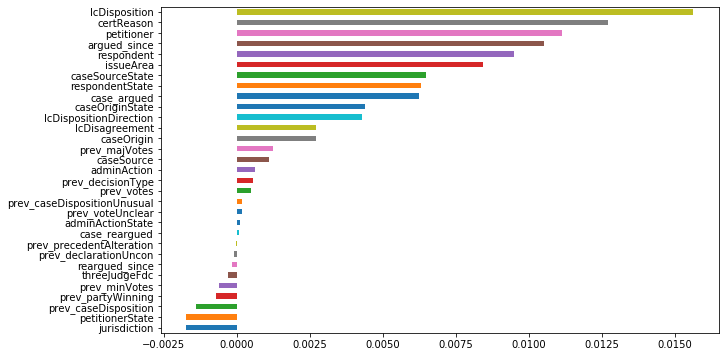

In [33]:
#Selecting features from perumation importances
feature_importances = pd.Series(dict(zip(features,perm.feature_importances_)))
feature_importances.sort_values().plot(kind='barh',figsize=(10,6))

In [34]:
selected_features = feature_importances[feature_importances >0].sort_values(ascending=False).index.tolist()
selected_features

['lcDisposition',
 'certReason',
 'petitioner',
 'argued_since',
 'respondent',
 'issueArea',
 'caseSourceState',
 'respondentState',
 'case_argued',
 'caseOriginState',
 'lcDispositionDirection',
 'lcDisagreement',
 'caseOrigin',
 'prev_majVotes',
 'caseSource',
 'adminAction',
 'prev_decisionType',
 'prev_votes',
 'prev_caseDispositionUnusual',
 'prev_voteUnclear',
 'adminActionState',
 'case_reargued']

In [35]:
#Running the model with selected features
rfc.fit(train[selected_features],y_train)
print("ROC score for Train is:",roc_auc_score(y_train,rfc.predict_proba(train[selected_features])[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,rfc.predict_proba(val[selected_features])[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,rfc.predict_proba(test[selected_features])[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,rfc.predict(train[selected_features])))
print("Accuracy score for Val is:",accuracy_score(y_val,rfc.predict(val[selected_features])))
print("Accuracy score for Test is:",accuracy_score(y_test,rfc.predict(test[selected_features])))

ROC score for Train is: 0.8760528507380816
ROC score for Val is: 0.6696062992125984
ROC score for Test is: 0.6596828111638032
Accuracy score for Train is: 0.738304304016122
Accuracy score for Val is: 0.673
Accuracy score for Test is: 0.671


In [ ]:
#Selected Feature Importances of the model from Random Forest Classifier
pd.Series(dict(zip(selected_features,rfc.feature_importances_))).sort_values().plot(kind='barh',figsize=(10,6))

In [ ]:
#Classification report for Test based on RandomForestClassifier
print(classification_report(y_val,rfc.predict(test[selected_features])))

In [36]:
from xgboost import XGBClassifier
xgboost = XGBClassifier(n_estimators=1000,learning_rate=0.01,objective='binary:logistic',max_depth=5,min_samples_split=5,random_state=31)

In [37]:
xgboost.fit(X_train,y_train,eval_metric='auc',eval_set=[(X_train,y_train),(X_val,y_val)],early_stopping_rounds=100)

[0]	validation_0-auc:0.653881	validation_1-auc:0.608523
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.653881	validation_1-auc:0.608523
[2]	validation_0-auc:0.654427	validation_1-auc:0.612547
[3]	validation_0-auc:0.654559	validation_1-auc:0.61347
[4]	validation_0-auc:0.654563	validation_1-auc:0.613021
[5]	validation_0-auc:0.65465	validation_1-auc:0.613953
[6]	validation_0-auc:0.654719	validation_1-auc:0.613763
[7]	validation_0-auc:0.656012	validation_1-auc:0.612456
[8]	validation_0-auc:0.660063	validation_1-auc:0.613742
[9]	validation_0-auc:0.660207	validation_1-auc:0.613725
[10]	validation_0-auc:0.660597	validation_1-auc:0.614229
[11]	validation_0-auc:0.660995	validation_1-auc:0.614411
[12]	validation_0-auc:0.666504	validation_1-auc:0.62148
[13]	validation_0-auc:0.667249	validation_1-auc:0.621256
[14]	validation_0-auc:0.667461	validation_1-auc:0.620242


[141]	validation_0-auc:0.716239	validation_1-auc:0.644414
[142]	validation_0-auc:0.716778	validation_1-auc:0.644677
[143]	validation_0-auc:0.716962	validation_1-auc:0.644914
[144]	validation_0-auc:0.717321	validation_1-auc:0.644778
[145]	validation_0-auc:0.71781	validation_1-auc:0.644906
[146]	validation_0-auc:0.71802	validation_1-auc:0.6451
[147]	validation_0-auc:0.718373	validation_1-auc:0.644871
[148]	validation_0-auc:0.719045	validation_1-auc:0.644796
[149]	validation_0-auc:0.719126	validation_1-auc:0.645037
[150]	validation_0-auc:0.719428	validation_1-auc:0.645003
[151]	validation_0-auc:0.720033	validation_1-auc:0.645272
[152]	validation_0-auc:0.72022	validation_1-auc:0.645475
[153]	validation_0-auc:0.720542	validation_1-auc:0.645557
[154]	validation_0-auc:0.721011	validation_1-auc:0.64557
[155]	validation_0-auc:0.720949	validation_1-auc:0.645736
[156]	validation_0-auc:0.721147	validation_1-auc:0.645583
[157]	validation_0-auc:0.72131	validation_1-auc:0.645626
[158]	validation_0-au

[283]	validation_0-auc:0.755583	validation_1-auc:0.653444
[284]	validation_0-auc:0.755796	validation_1-auc:0.653561
[285]	validation_0-auc:0.755923	validation_1-auc:0.653513
[286]	validation_0-auc:0.756206	validation_1-auc:0.653543
[287]	validation_0-auc:0.756397	validation_1-auc:0.653649
[288]	validation_0-auc:0.756542	validation_1-auc:0.65386
[289]	validation_0-auc:0.756578	validation_1-auc:0.653895
[290]	validation_0-auc:0.756853	validation_1-auc:0.653929
[291]	validation_0-auc:0.757051	validation_1-auc:0.654024
[292]	validation_0-auc:0.757195	validation_1-auc:0.654145
[293]	validation_0-auc:0.757356	validation_1-auc:0.654031
[294]	validation_0-auc:0.75763	validation_1-auc:0.654014
[295]	validation_0-auc:0.757787	validation_1-auc:0.65416
[296]	validation_0-auc:0.75792	validation_1-auc:0.654428
[297]	validation_0-auc:0.758083	validation_1-auc:0.654475
[298]	validation_0-auc:0.758285	validation_1-auc:0.654669
[299]	validation_0-auc:0.758388	validation_1-auc:0.654605
[300]	validation_0

[425]	validation_0-auc:0.779901	validation_1-auc:0.662945
[426]	validation_0-auc:0.780276	validation_1-auc:0.66275
[427]	validation_0-auc:0.780437	validation_1-auc:0.662733
[428]	validation_0-auc:0.780517	validation_1-auc:0.662677
[429]	validation_0-auc:0.780715	validation_1-auc:0.662738
[430]	validation_0-auc:0.780797	validation_1-auc:0.662755
[431]	validation_0-auc:0.78089	validation_1-auc:0.662733
[432]	validation_0-auc:0.781076	validation_1-auc:0.662707
[433]	validation_0-auc:0.781163	validation_1-auc:0.662686
[434]	validation_0-auc:0.781467	validation_1-auc:0.662686
[435]	validation_0-auc:0.781474	validation_1-auc:0.662694
[436]	validation_0-auc:0.781616	validation_1-auc:0.662772
[437]	validation_0-auc:0.781819	validation_1-auc:0.662867
[438]	validation_0-auc:0.782164	validation_1-auc:0.662755
[439]	validation_0-auc:0.782417	validation_1-auc:0.662917
[440]	validation_0-auc:0.782746	validation_1-auc:0.662927
[441]	validation_0-auc:0.782824	validation_1-auc:0.662884
[442]	validation

[567]	validation_0-auc:0.798565	validation_1-auc:0.666888
[568]	validation_0-auc:0.798761	validation_1-auc:0.666923
[569]	validation_0-auc:0.798816	validation_1-auc:0.666836
[570]	validation_0-auc:0.798969	validation_1-auc:0.66691
[571]	validation_0-auc:0.798998	validation_1-auc:0.666888
[572]	validation_0-auc:0.79918	validation_1-auc:0.666884
[573]	validation_0-auc:0.79924	validation_1-auc:0.666892
[574]	validation_0-auc:0.799281	validation_1-auc:0.666897
[575]	validation_0-auc:0.799427	validation_1-auc:0.66688
[576]	validation_0-auc:0.799547	validation_1-auc:0.667043
[577]	validation_0-auc:0.79973	validation_1-auc:0.667013
[578]	validation_0-auc:0.799713	validation_1-auc:0.667052
[579]	validation_0-auc:0.79977	validation_1-auc:0.667031
[580]	validation_0-auc:0.799874	validation_1-auc:0.666983
[581]	validation_0-auc:0.800004	validation_1-auc:0.667031
[582]	validation_0-auc:0.80004	validation_1-auc:0.667056
[583]	validation_0-auc:0.800141	validation_1-auc:0.667264
[584]	validation_0-au

[709]	validation_0-auc:0.811493	validation_1-auc:0.668787
[710]	validation_0-auc:0.811686	validation_1-auc:0.66886
[711]	validation_0-auc:0.811848	validation_1-auc:0.668791
[712]	validation_0-auc:0.811988	validation_1-auc:0.668959
[713]	validation_0-auc:0.812102	validation_1-auc:0.668933
[714]	validation_0-auc:0.812175	validation_1-auc:0.668938
[715]	validation_0-auc:0.812251	validation_1-auc:0.668886
[716]	validation_0-auc:0.812406	validation_1-auc:0.668864
[717]	validation_0-auc:0.812463	validation_1-auc:0.668808
[718]	validation_0-auc:0.812637	validation_1-auc:0.66895
[719]	validation_0-auc:0.812729	validation_1-auc:0.669002
[720]	validation_0-auc:0.812807	validation_1-auc:0.669067
[721]	validation_0-auc:0.812823	validation_1-auc:0.669037
[722]	validation_0-auc:0.812875	validation_1-auc:0.669119
[723]	validation_0-auc:0.813023	validation_1-auc:0.669132
[724]	validation_0-auc:0.813039	validation_1-auc:0.66911
[725]	validation_0-auc:0.813287	validation_1-auc:0.668925
[726]	validation_

[851]	validation_0-auc:0.825064	validation_1-auc:0.669688
[852]	validation_0-auc:0.825072	validation_1-auc:0.66974
[853]	validation_0-auc:0.825196	validation_1-auc:0.669749
[854]	validation_0-auc:0.825219	validation_1-auc:0.669826
[855]	validation_0-auc:0.825223	validation_1-auc:0.669792
[856]	validation_0-auc:0.825288	validation_1-auc:0.669917
[857]	validation_0-auc:0.82536	validation_1-auc:0.669779
[858]	validation_0-auc:0.825429	validation_1-auc:0.669753
[859]	validation_0-auc:0.825542	validation_1-auc:0.669723
[860]	validation_0-auc:0.825555	validation_1-auc:0.669736
[861]	validation_0-auc:0.825579	validation_1-auc:0.66974
[862]	validation_0-auc:0.825712	validation_1-auc:0.669602
[863]	validation_0-auc:0.825753	validation_1-auc:0.669593
[864]	validation_0-auc:0.825762	validation_1-auc:0.669636
[865]	validation_0-auc:0.825834	validation_1-auc:0.669602
[866]	validation_0-auc:0.825879	validation_1-auc:0.669559
[867]	validation_0-auc:0.825916	validation_1-auc:0.669464
[868]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, min_samples_split=5, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=31, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [38]:
xgboost.fit(train[selected_features],y_train,eval_metric='auc',eval_set=[(train[selected_features],y_train),(val[selected_features],y_val)],early_stopping_rounds=100)

[0]	validation_0-auc:0.653517	validation_1-auc:0.60579
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.65345	validation_1-auc:0.605855
[2]	validation_0-auc:0.654159	validation_1-auc:0.60908
[3]	validation_0-auc:0.653988	validation_1-auc:0.61075
[4]	validation_0-auc:0.654196	validation_1-auc:0.609891
[5]	validation_0-auc:0.654272	validation_1-auc:0.610456
[6]	validation_0-auc:0.654292	validation_1-auc:0.610586
[7]	validation_0-auc:0.654484	validation_1-auc:0.610633
[8]	validation_0-auc:0.658032	validation_1-auc:0.6115
[9]	validation_0-auc:0.65781	validation_1-auc:0.612445
[10]	validation_0-auc:0.659329	validation_1-auc:0.611623
[11]	validation_0-auc:0.65991	validation_1-auc:0.612409
[12]	validation_0-auc:0.665628	validation_1-auc:0.620945
[13]	validation_0-auc:0.665399	validation_1-auc:0.620017
[14]	validation_0-auc:0.666075	validation_1-auc:0.620604
[15]	

[142]	validation_0-auc:0.712743	validation_1-auc:0.646107
[143]	validation_0-auc:0.712883	validation_1-auc:0.646168
[144]	validation_0-auc:0.713415	validation_1-auc:0.646245
[145]	validation_0-auc:0.713594	validation_1-auc:0.646202
[146]	validation_0-auc:0.713822	validation_1-auc:0.646241
[147]	validation_0-auc:0.714137	validation_1-auc:0.646424
[148]	validation_0-auc:0.714512	validation_1-auc:0.646692
[149]	validation_0-auc:0.714896	validation_1-auc:0.646739
[150]	validation_0-auc:0.715017	validation_1-auc:0.646718
[151]	validation_0-auc:0.715247	validation_1-auc:0.646636
[152]	validation_0-auc:0.715698	validation_1-auc:0.646789
[153]	validation_0-auc:0.715955	validation_1-auc:0.646785
[154]	validation_0-auc:0.716301	validation_1-auc:0.646992
[155]	validation_0-auc:0.716489	validation_1-auc:0.647065
[156]	validation_0-auc:0.716782	validation_1-auc:0.64713
[157]	validation_0-auc:0.71721	validation_1-auc:0.647005
[158]	validation_0-auc:0.71775	validation_1-auc:0.647251
[159]	validation_

[284]	validation_0-auc:0.746387	validation_1-auc:0.656801
[285]	validation_0-auc:0.746478	validation_1-auc:0.656878
[286]	validation_0-auc:0.746836	validation_1-auc:0.657198
[287]	validation_0-auc:0.747028	validation_1-auc:0.657094
[288]	validation_0-auc:0.747241	validation_1-auc:0.657232
[289]	validation_0-auc:0.747482	validation_1-auc:0.657237
[290]	validation_0-auc:0.747588	validation_1-auc:0.657269
[291]	validation_0-auc:0.747743	validation_1-auc:0.65748
[292]	validation_0-auc:0.747774	validation_1-auc:0.657407
[293]	validation_0-auc:0.747851	validation_1-auc:0.657394
[294]	validation_0-auc:0.748034	validation_1-auc:0.657493
[295]	validation_0-auc:0.748248	validation_1-auc:0.657713
[296]	validation_0-auc:0.748417	validation_1-auc:0.657804
[297]	validation_0-auc:0.748582	validation_1-auc:0.657914
[298]	validation_0-auc:0.748904	validation_1-auc:0.657985
[299]	validation_0-auc:0.748924	validation_1-auc:0.657825
[300]	validation_0-auc:0.748994	validation_1-auc:0.657942
[301]	validatio

[426]	validation_0-auc:0.769736	validation_1-auc:0.664463
[427]	validation_0-auc:0.769905	validation_1-auc:0.664576
[428]	validation_0-auc:0.770125	validation_1-auc:0.664852
[429]	validation_0-auc:0.770228	validation_1-auc:0.664787
[430]	validation_0-auc:0.770292	validation_1-auc:0.6648
[431]	validation_0-auc:0.770818	validation_1-auc:0.665344
[432]	validation_0-auc:0.770912	validation_1-auc:0.665292
[433]	validation_0-auc:0.770998	validation_1-auc:0.665262
[434]	validation_0-auc:0.771255	validation_1-auc:0.66546
[435]	validation_0-auc:0.771443	validation_1-auc:0.665503
[436]	validation_0-auc:0.771527	validation_1-auc:0.665339
[437]	validation_0-auc:0.771711	validation_1-auc:0.6654
[438]	validation_0-auc:0.771764	validation_1-auc:0.665469
[439]	validation_0-auc:0.771953	validation_1-auc:0.665533
[440]	validation_0-auc:0.772446	validation_1-auc:0.665926
[441]	validation_0-auc:0.772506	validation_1-auc:0.665978
[442]	validation_0-auc:0.772614	validation_1-auc:0.665986
[443]	validation_0-

[568]	validation_0-auc:0.787249	validation_1-auc:0.670555
[569]	validation_0-auc:0.787302	validation_1-auc:0.670547
[570]	validation_0-auc:0.787389	validation_1-auc:0.670599
[571]	validation_0-auc:0.787509	validation_1-auc:0.67059
[572]	validation_0-auc:0.787587	validation_1-auc:0.670702
[573]	validation_0-auc:0.787774	validation_1-auc:0.670801
[574]	validation_0-auc:0.78781	validation_1-auc:0.670883
[575]	validation_0-auc:0.78801	validation_1-auc:0.670948
[576]	validation_0-auc:0.788138	validation_1-auc:0.670987
[577]	validation_0-auc:0.788178	validation_1-auc:0.671
[578]	validation_0-auc:0.788317	validation_1-auc:0.671026
[579]	validation_0-auc:0.788469	validation_1-auc:0.670952
[580]	validation_0-auc:0.788516	validation_1-auc:0.670961
[581]	validation_0-auc:0.788551	validation_1-auc:0.671099
[582]	validation_0-auc:0.788656	validation_1-auc:0.671043
[583]	validation_0-auc:0.788758	validation_1-auc:0.671112
[584]	validation_0-auc:0.788856	validation_1-auc:0.67119
[585]	validation_0-au

[710]	validation_0-auc:0.800457	validation_1-auc:0.672674
[711]	validation_0-auc:0.800517	validation_1-auc:0.672657
[712]	validation_0-auc:0.800632	validation_1-auc:0.672592
[713]	validation_0-auc:0.800709	validation_1-auc:0.672648
[714]	validation_0-auc:0.800803	validation_1-auc:0.672614
[715]	validation_0-auc:0.800998	validation_1-auc:0.672747
[716]	validation_0-auc:0.801058	validation_1-auc:0.672868
[717]	validation_0-auc:0.801112	validation_1-auc:0.67276
[718]	validation_0-auc:0.80114	validation_1-auc:0.672765
[719]	validation_0-auc:0.801143	validation_1-auc:0.672743
[720]	validation_0-auc:0.801199	validation_1-auc:0.672799
[721]	validation_0-auc:0.801334	validation_1-auc:0.672788
[722]	validation_0-auc:0.801466	validation_1-auc:0.672754
[723]	validation_0-auc:0.80153	validation_1-auc:0.672806
[724]	validation_0-auc:0.801624	validation_1-auc:0.672786
[725]	validation_0-auc:0.801784	validation_1-auc:0.672717
[726]	validation_0-auc:0.801908	validation_1-auc:0.672527
[727]	validation_

[852]	validation_0-auc:0.812265	validation_1-auc:0.674892
[853]	validation_0-auc:0.81244	validation_1-auc:0.674892
[854]	validation_0-auc:0.812505	validation_1-auc:0.674887
[855]	validation_0-auc:0.812667	validation_1-auc:0.674857
[856]	validation_0-auc:0.812723	validation_1-auc:0.674857
[857]	validation_0-auc:0.812869	validation_1-auc:0.674848
[858]	validation_0-auc:0.81298	validation_1-auc:0.674779
[859]	validation_0-auc:0.812994	validation_1-auc:0.674797
[860]	validation_0-auc:0.81301	validation_1-auc:0.674797
[861]	validation_0-auc:0.813197	validation_1-auc:0.674697
[862]	validation_0-auc:0.813367	validation_1-auc:0.674788
[863]	validation_0-auc:0.813483	validation_1-auc:0.674805
[864]	validation_0-auc:0.813561	validation_1-auc:0.674779
[865]	validation_0-auc:0.813592	validation_1-auc:0.674766
[866]	validation_0-auc:0.813737	validation_1-auc:0.674801
[867]	validation_0-auc:0.813929	validation_1-auc:0.674844
[868]	validation_0-auc:0.814026	validation_1-auc:0.674831
[869]	validation_

[994]	validation_0-auc:0.825714	validation_1-auc:0.675155
[995]	validation_0-auc:0.825841	validation_1-auc:0.675142
[996]	validation_0-auc:0.825892	validation_1-auc:0.675138
[997]	validation_0-auc:0.8262	validation_1-auc:0.675051
[998]	validation_0-auc:0.826251	validation_1-auc:0.675077
[999]	validation_0-auc:0.826463	validation_1-auc:0.675129


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, min_samples_split=5, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=31, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [39]:
#Getting Perumtation importances based on xgboost
perm = PermutationImportance(xgboost, random_state=1,scoring='roc_auc').fit(val[selected_features], y_val)
eli5.show_weights(perm,feature_names=selected_features,top=None)

Weight,Feature
0.0342 ± 0.0216,certReason
0.0320 ± 0.0205,argued_since
0.0160 ± 0.0145,issueArea
0.0143 ± 0.0069,lcDispositionDirection
0.0137 ± 0.0089,caseSource
0.0135 ± 0.0081,respondent
0.0128 ± 0.0045,caseOriginState
0.0115 ± 0.0093,lcDisposition
0.0109 ± 0.0054,lcDisagreement
0.0099 ± 0.0050,caseSourceState


In [47]:
print("ROC score for Test using randomforest is:",roc_auc_score(y_test,rfc.predict_proba(test[selected_features])[:,1]))

ROC score for Test using randomforest is: 0.6596828111638032


In [41]:
print("ROC score for Val is:",roc_auc_score(y_val,xgboost.predict_proba(val[selected_features])[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,xgboost.predict_proba(test[selected_features])[:,1]))

ROC score for Val is: 0.6754438571890843
ROC score for Test is: 0.6532896451747146


In [43]:
accuracy_score(y_test,xgboost.predict(test[selected_features]))

0.663

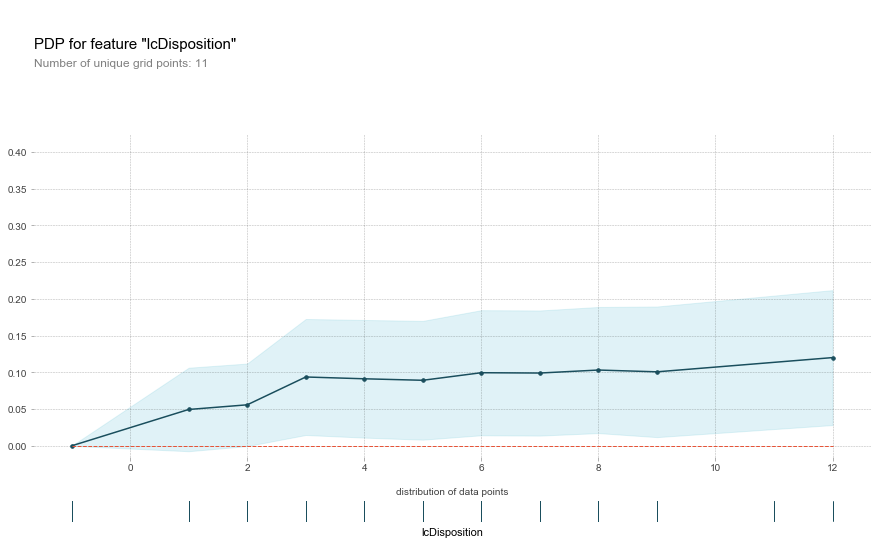

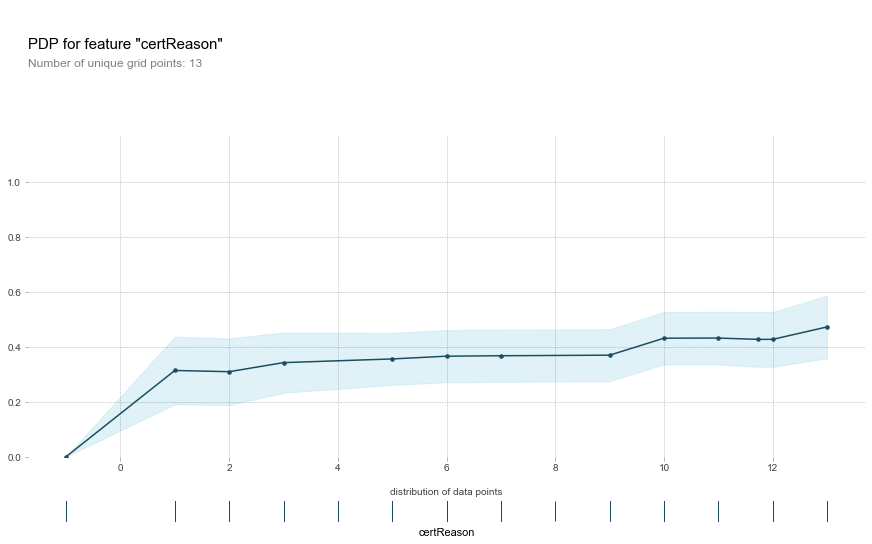

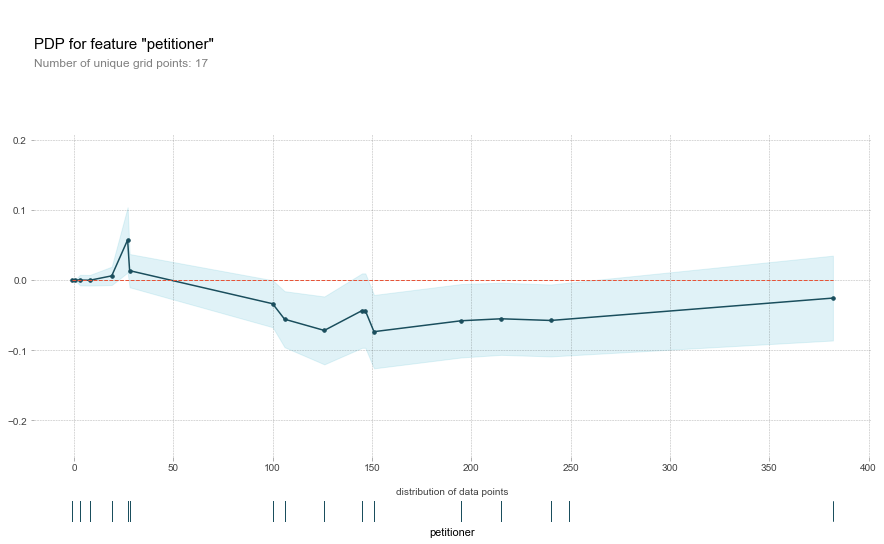

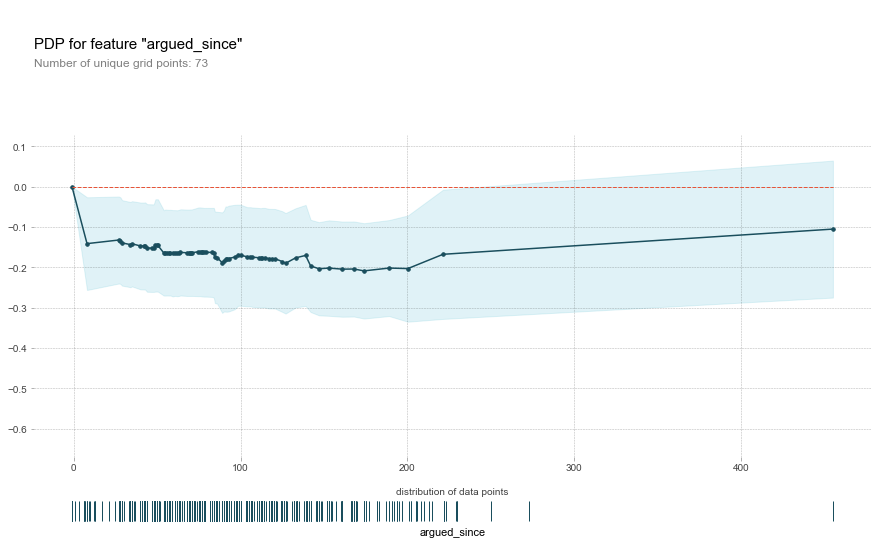

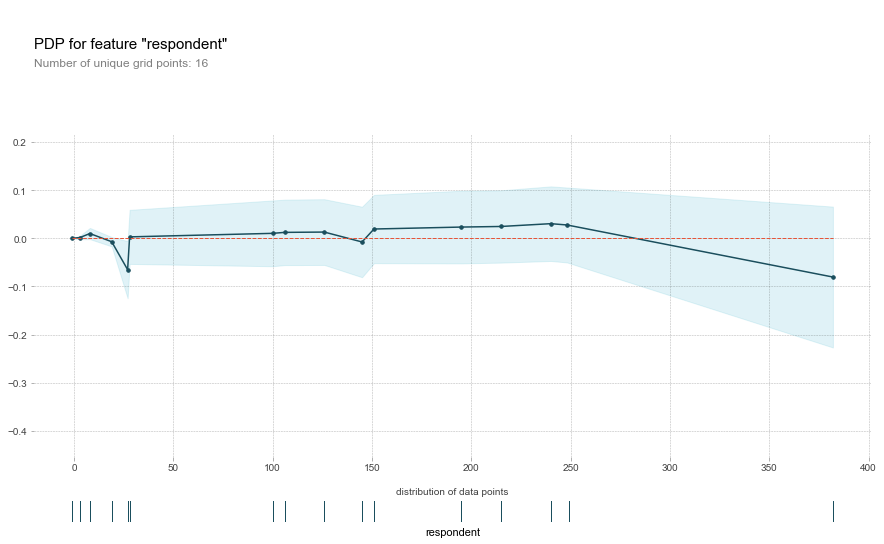

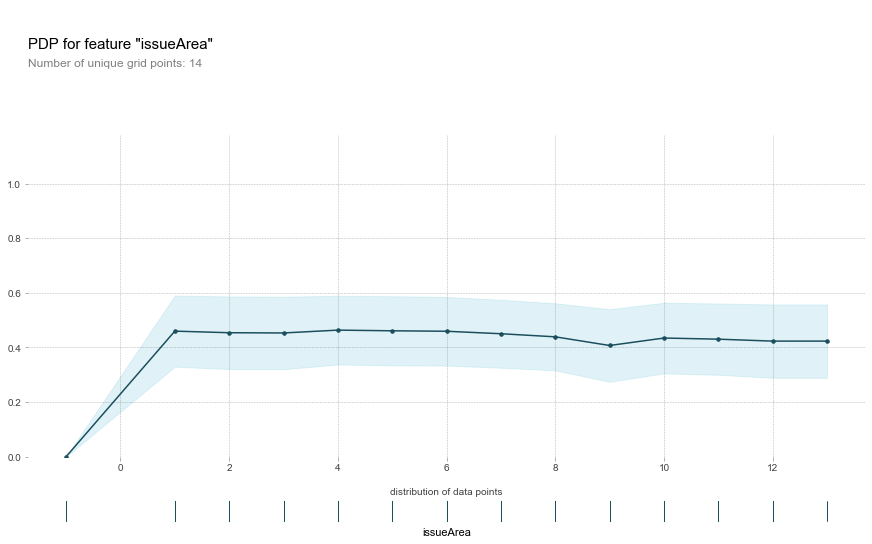

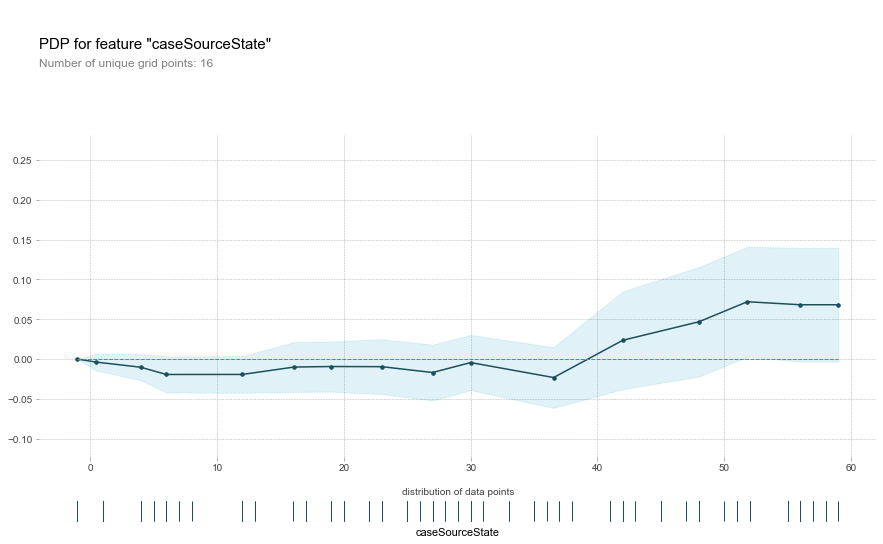

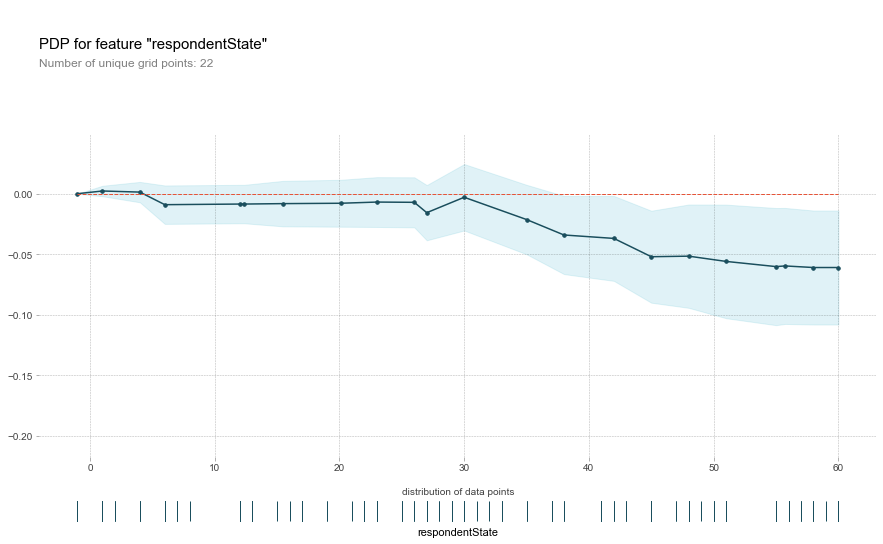

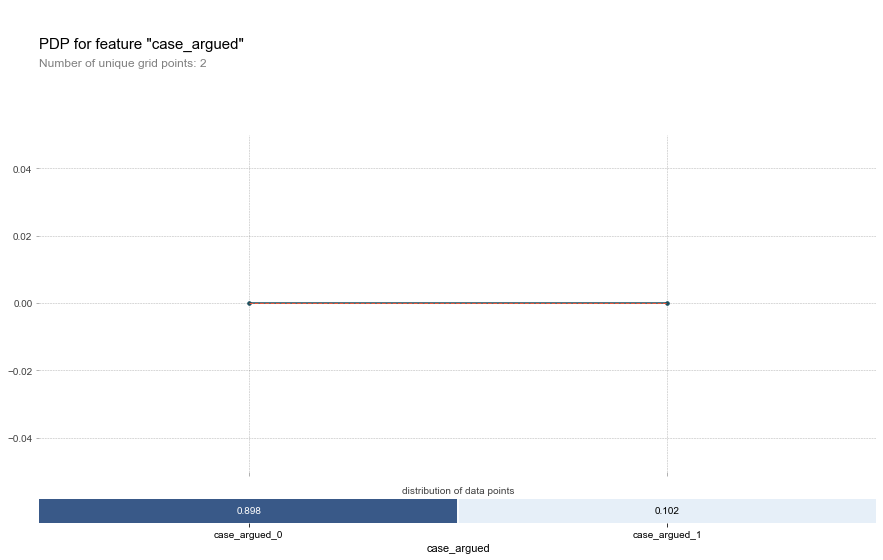

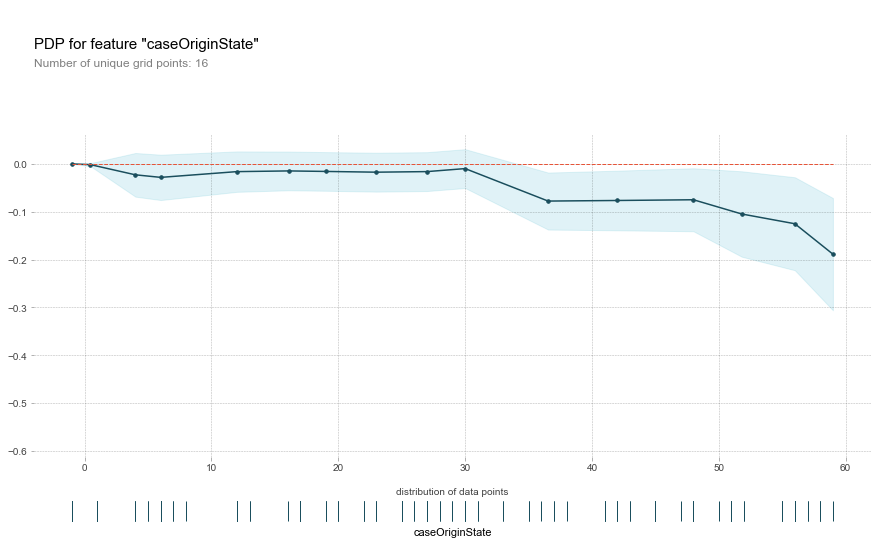

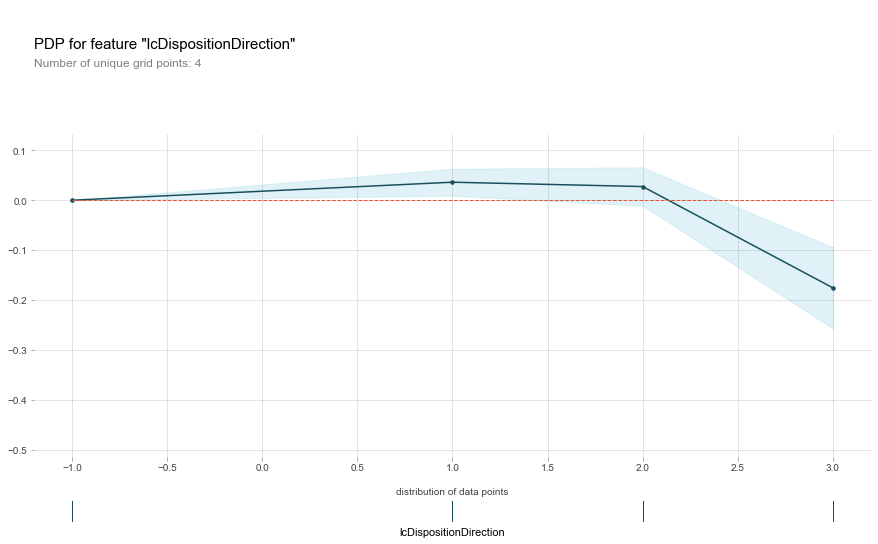

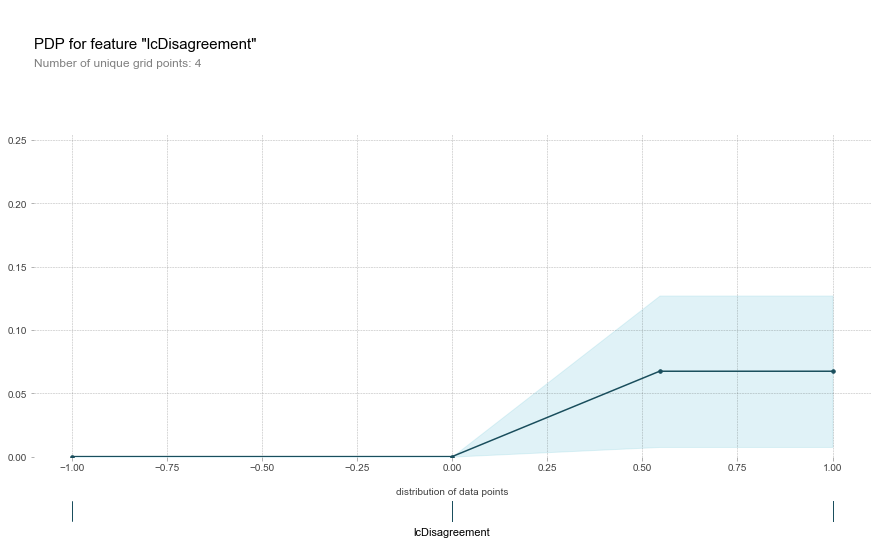

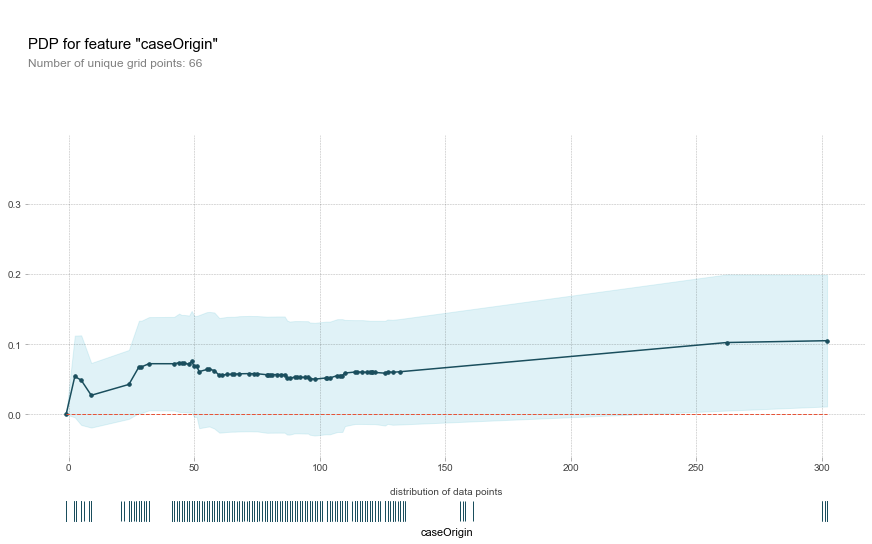

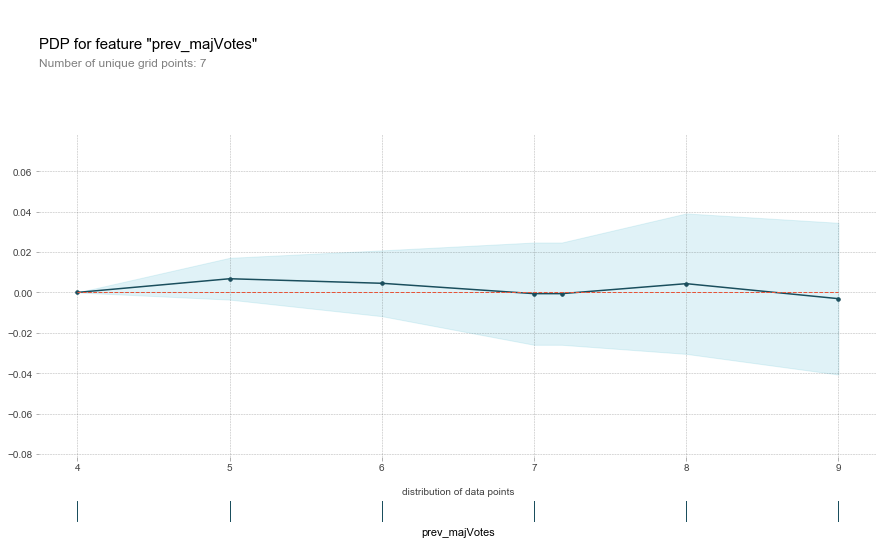

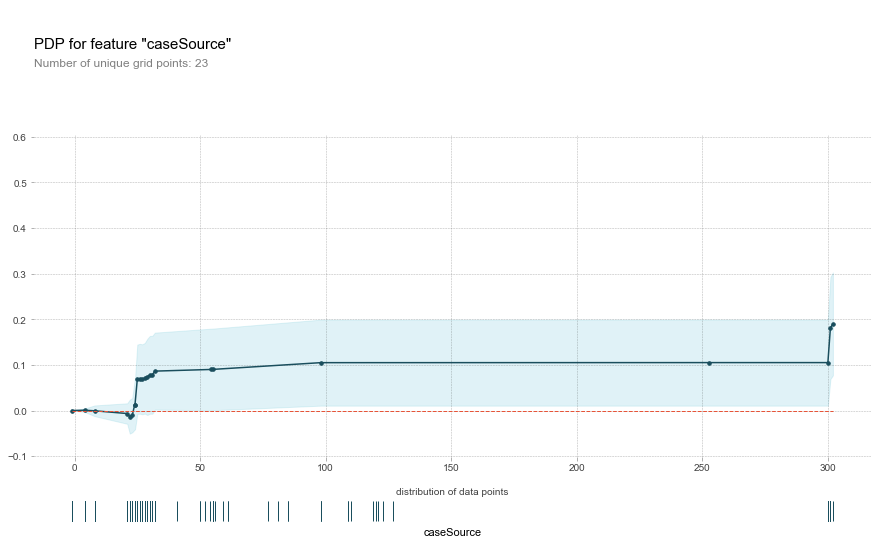

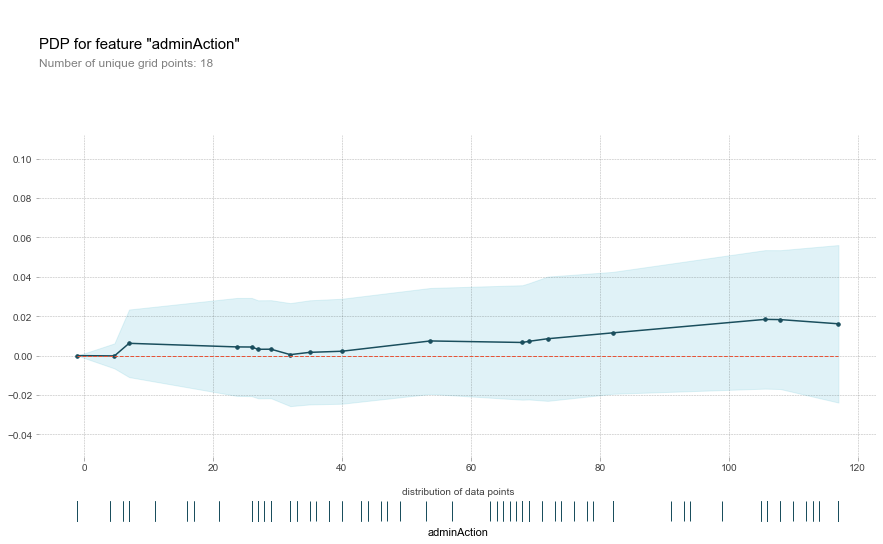

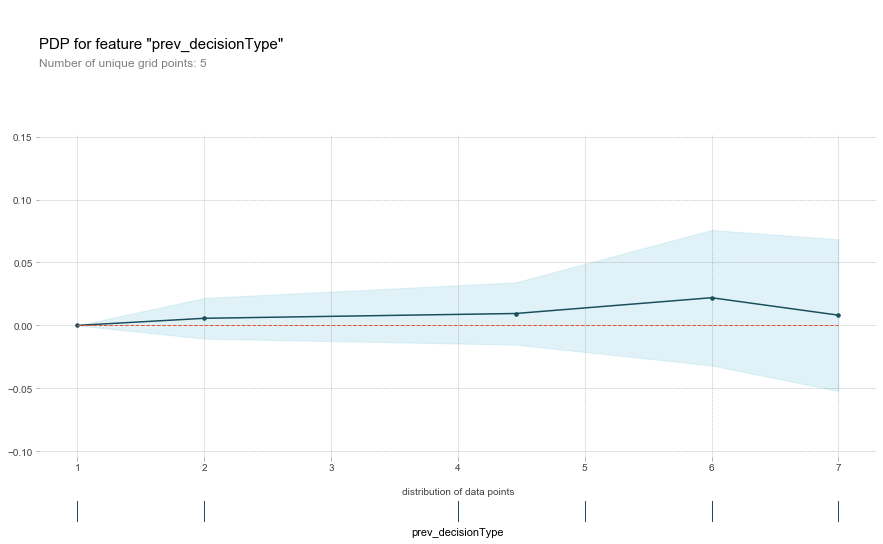

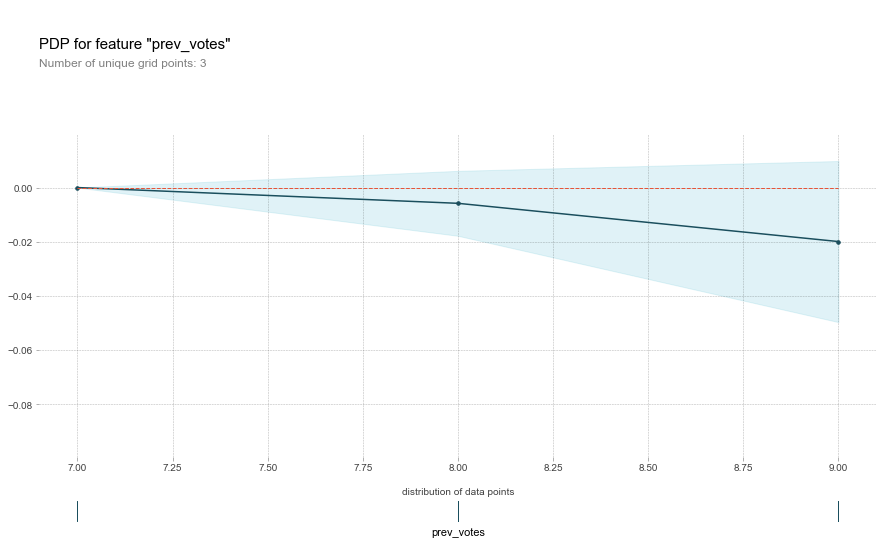

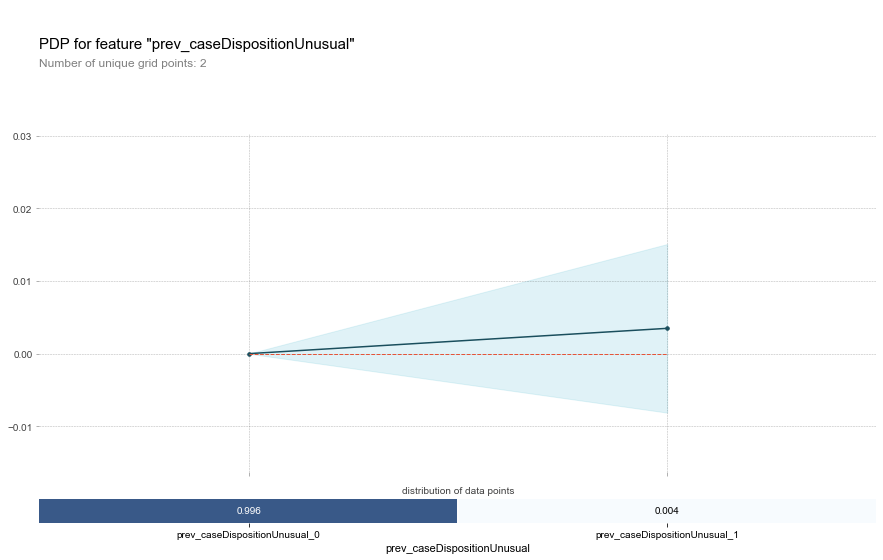

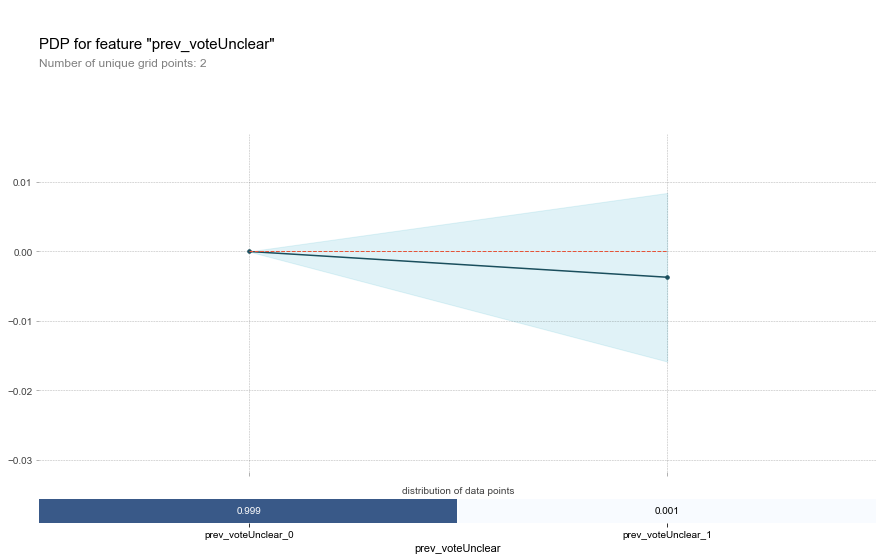

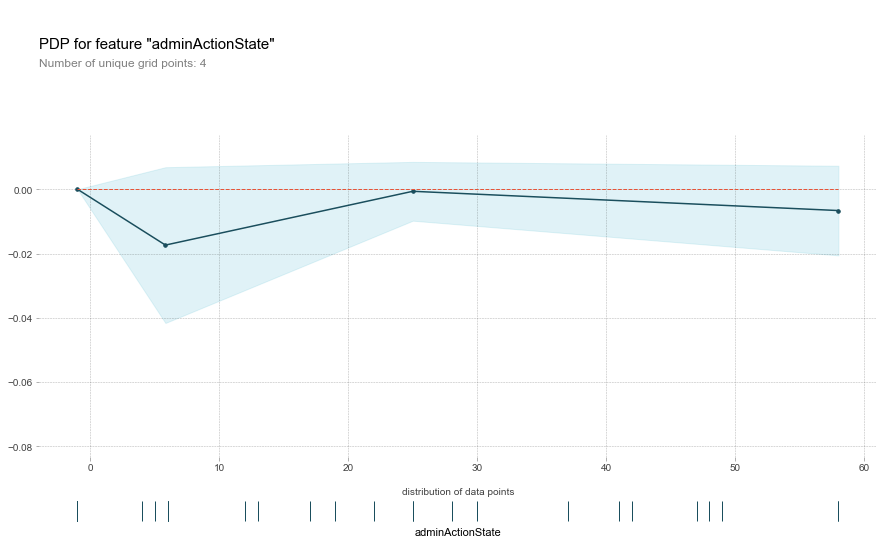

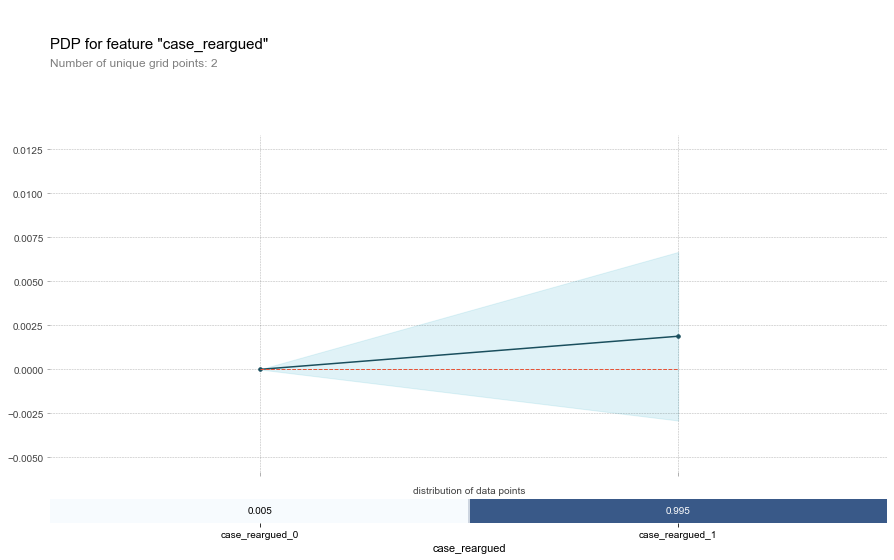

In [46]:
#Plotting pdp plot for each of the features
for f in selected_features:

    isolated = pdp_isolate(
    model=xgboost,
    dataset=val[selected_features],
    model_features=selected_features,
    feature=f,
    num_grid_points=100)

    pdp_plot(isolated,feature_name=f,plot_pts_dist=True)